In [1]:
from datetime import timedelta
import sciris as sc
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from collections import Counter
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import random
import needleman_wunsch

sns.set_style("white")
sns.set_context("talk")

```python
param_dict = {
    "r0": 1.5,
    "k": 0.75,
    "seed_infections": 1,
    "total_infections": 26,
    "gen_length": 1000,  # Didn't use actual genome length 29903 to reduce computational time
    "prop_sampled": 1,
    "sampling_delay": 0.0,
}

para_name = "sampling_delay"
param_range = [0.0, 0.1]

simulations = run_simulations(param_dict, para_name, param_range, use_parallel=True)
sc.save("/Users/ydnkka/Desktop/Repositories/PESC-Activity/outbreaks.obj", simulations)
```

In [2]:
simulations = sc.load("outbreaks.obj")
outbreak = simulations[0]

In [3]:
tree = outbreak.tree

# original_nodes = list(tree.nodes())
# case_names = [f"P-{i}" for i in range(1, len(original_nodes)+1)]
# np.random.shuffle(case_names)
# node_name_mapping = {original_nodes[i]: case_names[i] for i in range(len(original_nodes))}
# sc.save("node_name_mapping.obj", node_name_mapping)

node_name_mapping = sc.load("node_name_mapping.obj")

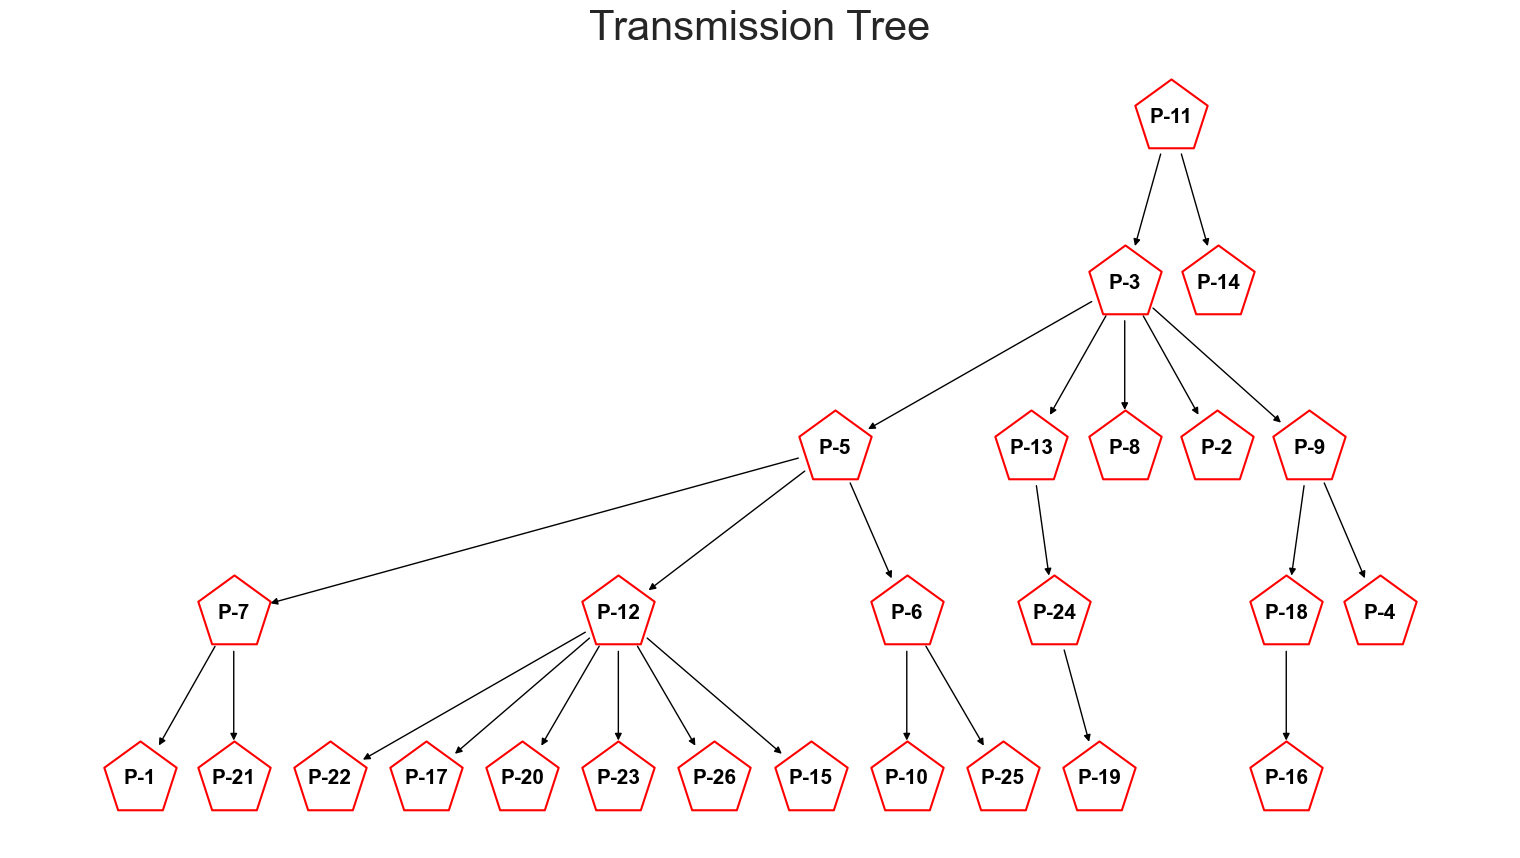

In [4]:
tree = nx.relabel_nodes(tree, node_name_mapping)
pos = nx.nx_agraph.graphviz_layout(tree, prog="dot")

fig_size = (15, 8)
plt.figure(figsize=fig_size)  # Increase the figure size
nx.draw(tree,
        pos,
        with_labels=True,
        width=1,
        edge_color='black',
        node_size=3000,
        font_color='black',
        font_size=15,
        font_weight='bold',
        node_color='white',
        edgecolors='red',
        node_shape='p')

plt.title("Transmission Tree", fontsize=30)
plt.savefig("transmission_tree.png", dpi=300, bbox_inches='tight')
plt.show()

In [5]:
plt.figure(figsize=fig_size)
nx.draw(tree,
        pos,
        with_labels=True,
        width=1,
        edge_color='white',
        node_size=3000,
        font_color='black',
        font_size=15,
        font_weight='bold',
        node_color='white',
        edgecolors='red',
        node_shape='p')

plt.title("Transmission Tree", fontsize=30)
plt.savefig("transmission_tree_blank.png", dpi=300, bbox_inches='tight')
plt.close()

In [30]:
transmission_data = nx.to_pandas_edgelist(tree)
transmission_data = transmission_data[["source", "target"]].copy()
transmission_data.rename(columns={"source": "Infector", "target": "Infectee"}, inplace=True)

transmission_data.to_csv("transmission_data.csv", index=False)

transmission_data.head()

,Infector,Infectee
0,P-11,P-3
1,P-11,P-14
2,P-3,P-5
3,P-3,P-13
4,P-3,P-8


In [31]:
transmission_data_student = pd.DataFrame()
transmission_data_student["Case 1"] = [""]*len(transmission_data)
transmission_data_student["Case 2"] = ""
transmission_data_student["Infector"] = ""
transmission_data_student["Infectee"] = ""

transmission_data_student.to_csv("transmission_data_student.csv")

In [32]:
cases = pd.DataFrame(dict(tree.nodes)).T
cases = cases[["sample_date", "exp_date"]].copy().astype(int)

cases.reset_index(inplace=True, names=["Patient ID"])
cases.rename(columns={"exp_date": "Exposure Date", "sample_date": "Testing Date"}, inplace=True)

cases.sort_values("Exposure Date", inplace=True)

start_date = pd.Timestamp("2020-01-01")
cases["Exposure Date"] = cases["Exposure Date"].apply(lambda x: start_date + timedelta(days=x - 1))
cases["Exposure Date"] = cases["Exposure Date"].dt.strftime('%b-%d')

cases["Testing Date"] = cases["Testing Date"].apply(lambda x: start_date + timedelta(days=x - 1))
cases["Testing Date"] = cases["Testing Date"].dt.strftime('%b-%d')


# Assign locations (siblings and transmission pairs tend to share)
location_variation = 0.5  # Probability of assigning a different location
locations = {}
available_locations = [f"DZ-{i}" for i in range(20)]
assigned_locations = {}

for node in tree.nodes:
    if node == transmission_data.iloc[0, 0]:
        assigned_locations[node] = random.choice(available_locations)  # Root gets a random location
    else:
        parent = list(tree.predecessors(node))[0]
        if random.random() < location_variation:  # Occasionally assign a different location
            assigned_locations[node] = random.choice(available_locations)
        else:
            assigned_locations[node] = assigned_locations[parent]  # Inherit parent's location

# Simulate known contacts (infected and non-infected)
def contacts_proportional_to_degree(G, total_contacts, alpha=1.0):
    degrees = dict(G.degree())
    weighted_degrees = {node: degree**alpha for node, degree in degrees.items()}
    total_weighted_degree = sum(weighted_degrees.values())
    proportions = {node: deg/total_weighted_degree for node, deg in weighted_degrees.items()}

    # Distribute samples according to proportions
    sample_counts = {node: 1 for node in G.nodes}
    remaining_samples = total_contacts - len(G.nodes)
    if remaining_samples > 0:
        raw_counts = {node: remaining_samples * prop for node, prop in proportions.items()}

        # First, allocate the integer part
        for node, count in raw_counts.items():
            int_count = int(count)
            sample_counts[node] += int_count
            remaining_samples -= int_count

        # Then distribute remaining samples probabilistically based on the fractional parts
        frac_parts = {node: count - int(count) for node, count in raw_counts.items()}
        nodes = list(frac_parts.keys())
        probs = list(frac_parts.values())

        # Normalize probabilities
        total_prob = sum(probs)
        if total_prob > 0:  # Avoid division by zero
            probs = [p/total_prob for p in probs]

            # Sample nodes with probability proportional to fractional parts
            sampled_nodes = np.random.choice(nodes, size=int(remaining_samples), p=probs, replace=True)
            for node in sampled_nodes:
                sample_counts[node] += 1
    return sample_counts

known_contacts = {}
contacts = contacts_proportional_to_degree(tree, total_contacts=75, alpha=1.5)
total_population = set(tree.nodes).union([f"C-{i}" for i in range(len(tree.nodes) + 1, 1001)])
tracing_probability = 0.2
traced_contacts = set()

for node in tree.nodes:
    all_contacts = set(tree.successors(node))   # Direct children are known contacts
    traced = set()
    for contact in all_contacts:
        if random.random() > tracing_probability:
            traced.add(contact)

    known_contacts[node] = traced

    traced_contacts.update(traced)

    # Add random extra contacts (infected or not)
    possible_contacts = list(total_population - {node} - known_contacts[node])
    extra_contacts = random.sample(possible_contacts, contacts[node])
    known_contacts[node].update(extra_contacts)
    traced_contacts.update(extra_contacts)

non_infected_contacts = {}
for node in traced_contacts:
    loc = assigned_locations.get(node, 0)
    if loc == 0:
        non_infected_contacts[node] = random.choice(available_locations)

# data = [assigned_locations, known_contacts, non_infected_contacts]
# sc.save("data.obj", data)

In [33]:
data = sc.load("data.obj")
assigned_locations, known_contacts, non_infected_contacts = data

locations = pd.DataFrame(assigned_locations.items(), columns=["Patient ID", "Data Zone"])
contacts_list = [(k, list(v)) for k, v in known_contacts.items()]
contacts = pd.DataFrame(contacts_list, columns=["Patient ID", "Known Contact"])
cases = cases.merge(locations, on="Patient ID")
cases = cases.merge(contacts, on="Patient ID")
non_infected_contacts = pd.DataFrame(non_infected_contacts.items(), columns=["Contact ID", "Data-Zone"])

In [34]:
cases["Known Contact"] = cases["Known Contact"].apply(lambda x: ", ".join(x))
contacts["Known Contact"] = contacts["Known Contact"].apply(lambda x: ", ".join(x))

In [11]:
cases.to_csv("master_cases.csv", index=False)
cases[["Patient ID", "Testing Date", "Data Zone"]].to_csv("cases_for_students_1.csv", index=False)
contacts.to_csv("known_contacts_for_students.csv", index=False)
non_infected_contacts.to_csv("non_infected_contacts_for_students.csv", index=False)

In [12]:
cases_student = cases[["Patient ID", "Testing Date", "Data Zone"]].copy()
cases_student["Exposure Date"] = ""
cases_student.to_csv("cases_for_students_2.csv", index=False)

In [43]:
estimate_ro = dict(tree.out_degree())
estimate_ro = pd.DataFrame(estimate_ro.items(), columns=["Patient ID", "Offspring"])

In [44]:
last_generation = cases[cases["Testing Date"] == "Jan-31"]["Patient ID"]

estimate_ro = estimate_ro[~estimate_ro["Patient ID"].isin(last_generation)]

In [45]:
estimate_ro

,Patient ID,Offspring
0,P-11,2
1,P-3,5
2,P-14,0
3,P-5,3
4,P-13,1
5,P-8,0
6,P-2,0
7,P-9,2
8,P-7,2
9,P-12,6


In [46]:
estimate_ro["Offspring"].mean()

np.float64(1.7857142857142858)

In [47]:
estimate_ro["Offspring"] = ""

estimate_ro.to_csv("offspring_distribution.csv", index=False)

In [13]:
def get_distance_matrix(sequences):
    keys = list(sequences.keys())
    matrix = np.array(list(sequences.values()))

    # Convert nucleotide sequences to numerical values for Hamming distance calculation
    mapping = {'A': 0, 'C': 1, 'G': 2, 'T': 3}

    seq_matrix_num = np.vectorize(mapping.get)(matrix)
    distances = pdist(seq_matrix_num, metric='hamming')  # Proportion of differing sites
    return squareform(distances), keys, matrix


sequences_dict = outbreak.result.linearSeqSim
shuffled_keys = list(sequences_dict.keys())
random.shuffle(shuffled_keys)
shuffled_sequences_dict = {key: sequences_dict[key] for key in shuffled_keys}
hamming_distances, ids, seq_matrix = get_distance_matrix(shuffled_sequences_dict)
hamming_matrix = hamming_distances * seq_matrix.shape[1]  # convert to number of differing positions
hamming_matrix = hamming_matrix.astype(int)

ids = [node_name_mapping[x] for x in ids]
pairwise_distances = pd.DataFrame(hamming_matrix, index=ids, columns=ids)

pairwise_distances.columns.name = "Patient ID"
pairwise_distances.index.name = "Patient ID"

pairwise_distances.to_csv("pairwise_distances.csv")

pairwise_distances.iloc[: 10, :10]

Patient ID,P-23,P-7,P-5,P-25,P-11,P-24,P-6,P-14,P-10,P-18
Patient ID,,,,,,,,,,
P-23,0,3,2,4,4,5,3,5,4,5
P-7,3,0,1,3,3,4,2,4,3,4
P-5,2,1,0,2,2,3,1,3,2,3
P-25,4,3,2,0,4,5,1,5,2,5
P-11,4,3,2,4,0,3,3,1,4,3
P-24,5,4,3,5,3,0,4,4,5,4
P-6,3,2,1,1,3,4,0,4,1,4
P-14,5,4,3,5,1,4,4,0,5,4
P-10,4,3,2,2,4,5,1,5,0,5


In [14]:
def generate_irregular_grid(rows, cols, noise_level=0.3):
    """
    Generate an irregular grid of towns.

    :param rows: Number of rows in the grid
    :param cols: Number of columns in the grid
    :param noise_level: Amount of irregularity in grid lines
    :return: Grid vertices
    """
    # Set random seed for reproducibility
    random.seed(42)
    np.random.seed(42)

    # Initialize grid points
    grid = np.zeros((rows + 1, cols + 1, 2))

    # Create base grid
    for r in range(rows + 1):
        for c in range(cols + 1):
            # Base coordinates
            x = c
            y = r

            # Add noise to make lines irregular
            x += random.uniform(-noise_level, noise_level)
            y += random.uniform(-noise_level, noise_level)

            grid[r, c] = [x, y]

    return grid

def create_DZ_boundaries(town_names, town_values=None, colormap='YlOrRd', filename="data_zone_boundaries.png"):
    # Determine grid size based on number of towns
    rows = int(np.ceil(np.sqrt(len(town_names))))
    cols = int(np.ceil(len(town_names) / rows))

    # Generate irregular grid
    grid = generate_irregular_grid(rows, cols)

    # Create plot
    plt.figure(figsize=(12, 10), facecolor='white')
    ax = plt.gca()
    ax.set_facecolor('white')

    # Prepare colormap
    if town_values:
        # Normalize values for color mapping
        values = list(town_values.values())
        norm = mcolors.Normalize(vmin=min(values), vmax=max(values))
        scalar_map = cm.ScalarMappable(norm=norm, cmap=plt.get_cmap(colormap))

    # Draw grid cells as towns
    town_index = 0
    for r in range(rows):
        for c in range(cols):
            # Skip if we've used all town names
            if town_index >= len(town_names):
                break

            # Get the four corners of this cell
            cell_points = [
                grid[r, c],
                grid[r, c+1],
                grid[r+1, c+1],
                grid[r+1, c]
            ]

            # Determine fill color
            fill_color = 'white'
            if town_values and town_names[town_index] in town_values:
                fill_color = scalar_map.to_rgba(town_values[town_names[town_index]])

            # Create polygon for the cell
            polygon = plt.Polygon(cell_points,
                                  facecolor=fill_color,
                                  edgecolor='black',
                                  linewidth=1)  # Slight transparency
            ax.add_patch(polygon)

            # Add town name
            centroid = np.mean(cell_points, axis=0)
            plt.text(centroid[0], centroid[1],
                     town_names[town_index],
                     ha='center',
                     va='center',
                     fontsize=10,
                     fontweight='bold',
                     )

            town_index += 1

    # Add colorbar if values provided
    if town_values:
        plt.colorbar(scalar_map,
                     label='Number of Cases',
                     ax=ax,
                     shrink=0.8)

    # Set plot limits with some padding
    plt.xlim(-0.5, cols + 0.5)
    plt.ylim(-0.5, rows + 0.5)

    # Remove ticks
    plt.xticks([])
    plt.yticks([])

    plt.title("Map of Data Zones", fontsize=25)

    # Save the plot
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

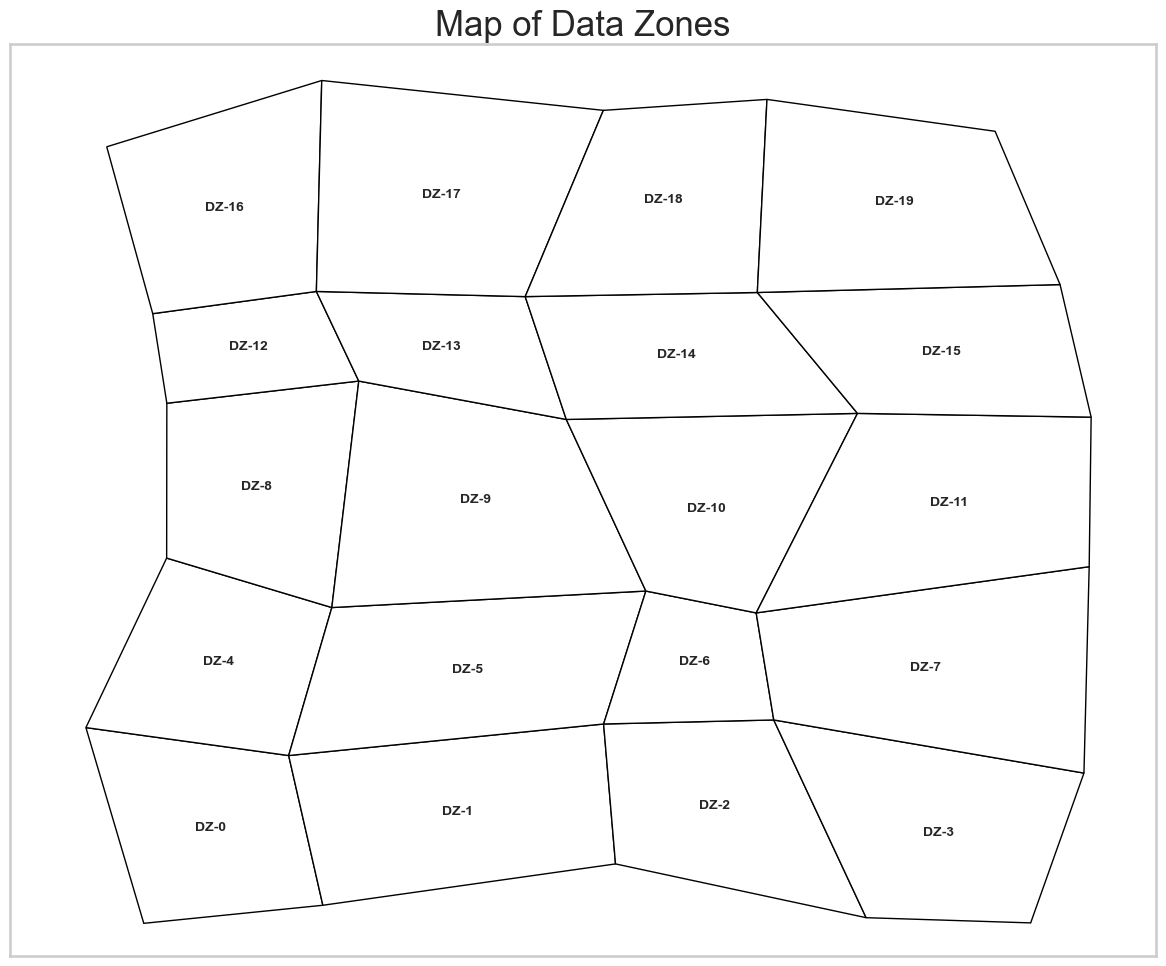

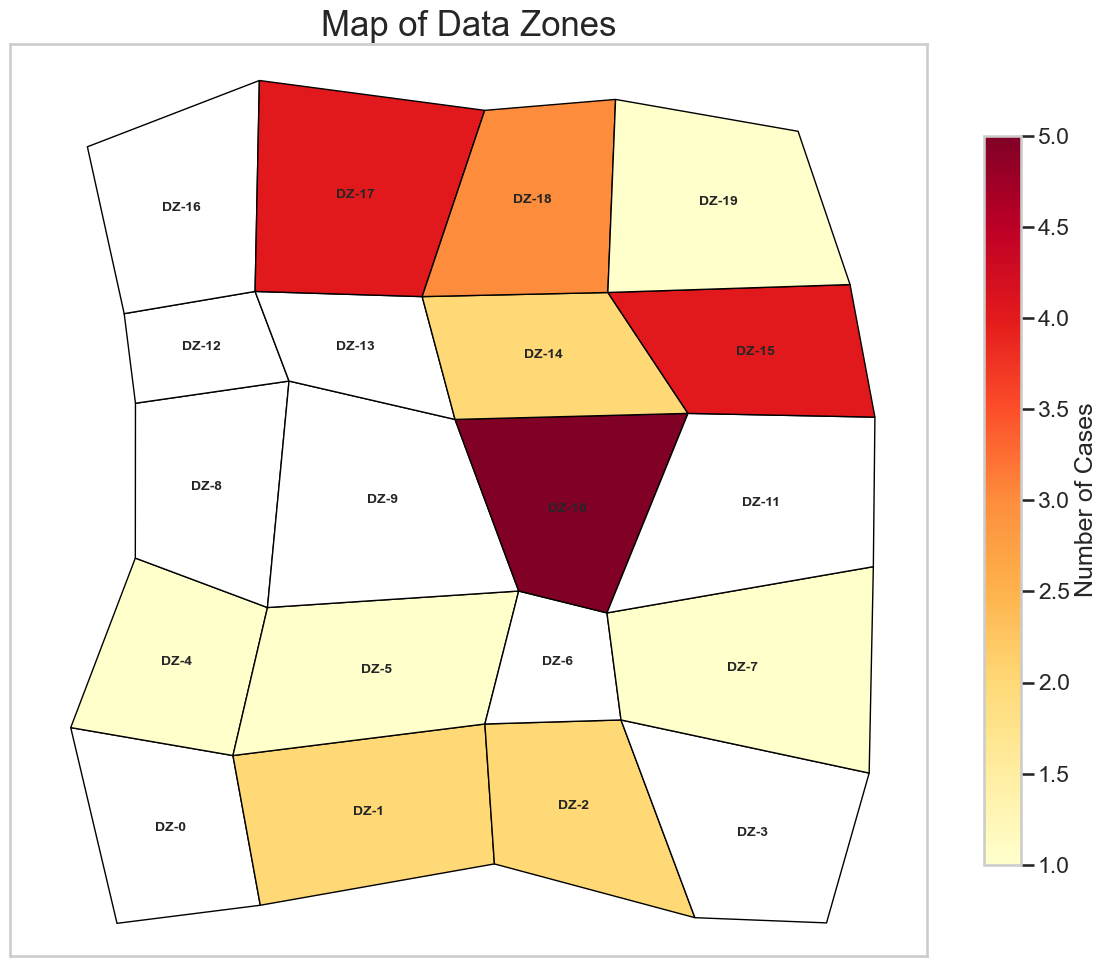

In [15]:
create_DZ_boundaries(available_locations, filename="data_zone_boundaries.png")
create_DZ_boundaries(available_locations, dict(Counter(locations["Data Zone"])), filename="data_zone_boundaries_risk_areas.png")

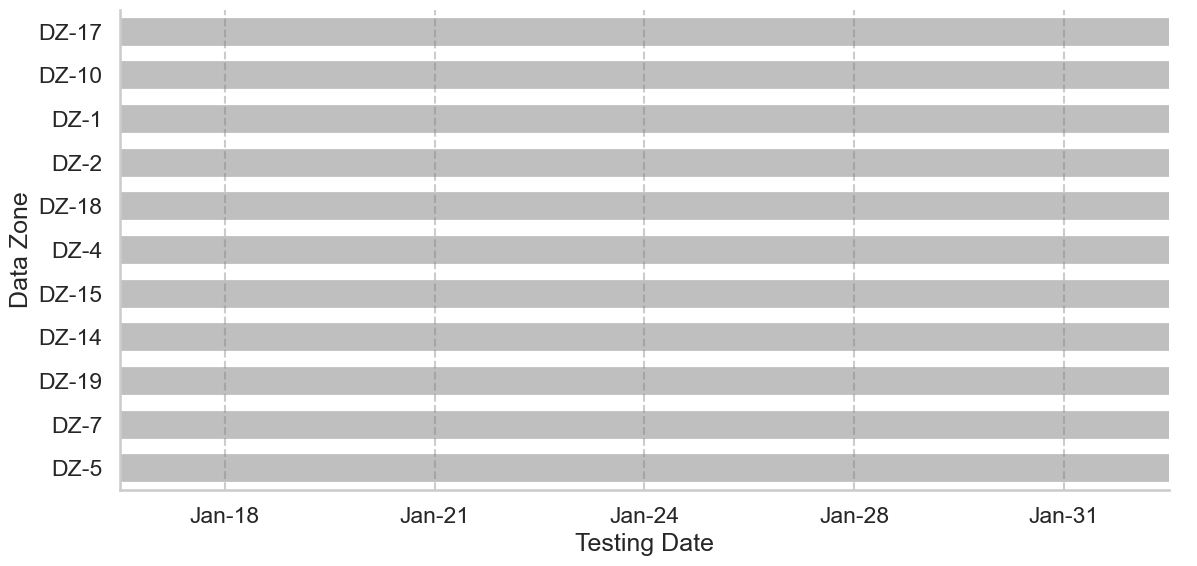

In [16]:
sns.catplot(cases, x="Testing Date", y="Data Zone", height=6, aspect=2, color="red", marker="p", size=10, alpha=0)
plt.grid(True,axis='x', linestyle='--')
plt.grid(True,axis='y', alpha=0.5, linewidth=20, color='grey')
plt.savefig("spatio_temporal_analysis_demo.png", dpi=300, bbox_inches='tight')
plt.show()

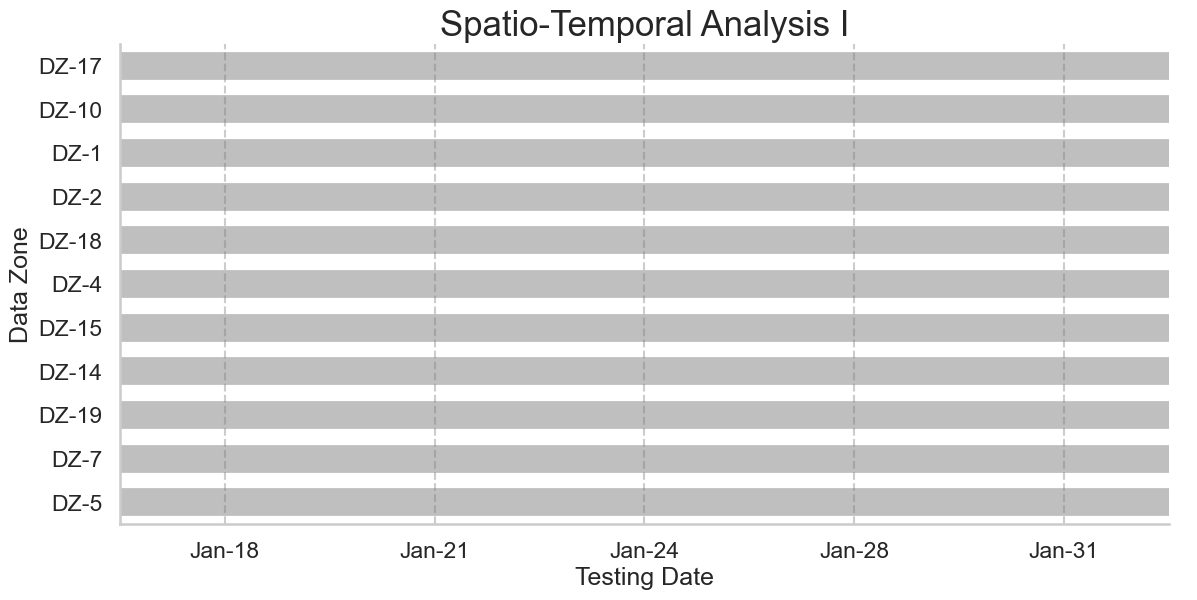

In [17]:
sns.catplot(cases, x="Testing Date", y="Data Zone", height=6, aspect=2, color="red", marker="p", size=10, alpha=0)
plt.grid(True,axis='x', linestyle='--')
plt.grid(True,axis='y', alpha=0.5, linewidth=20, color='grey')
plt.title("Spatio-Temporal Analysis I", fontsize=25)
plt.savefig("spatio_temporal_analysis_student_1.png", dpi=300, bbox_inches='tight')
plt.show()

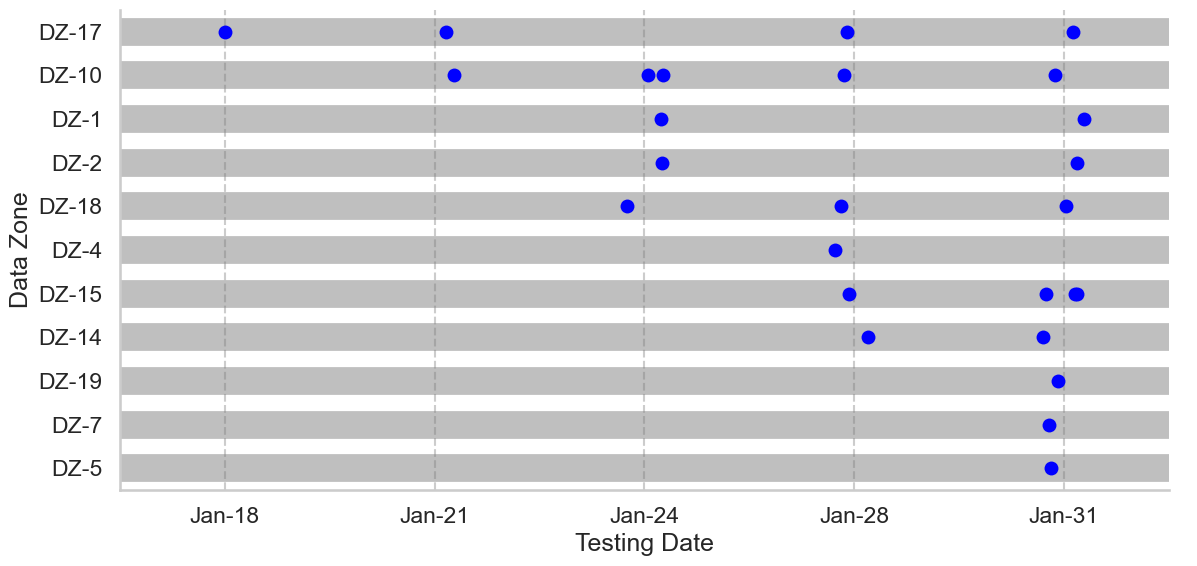

In [18]:
sns.catplot(cases, x="Testing Date", y="Data Zone", height=6, aspect=2, color="blue", size=10)
plt.grid(True,axis='x', linestyle='--')
plt.grid(True,axis='y', alpha=0.5, linewidth=20, color='grey')
plt.title("", fontsize=25)
plt.savefig("spatio_temporal_analysis_1.png", dpi=300, bbox_inches='tight')
plt.show()

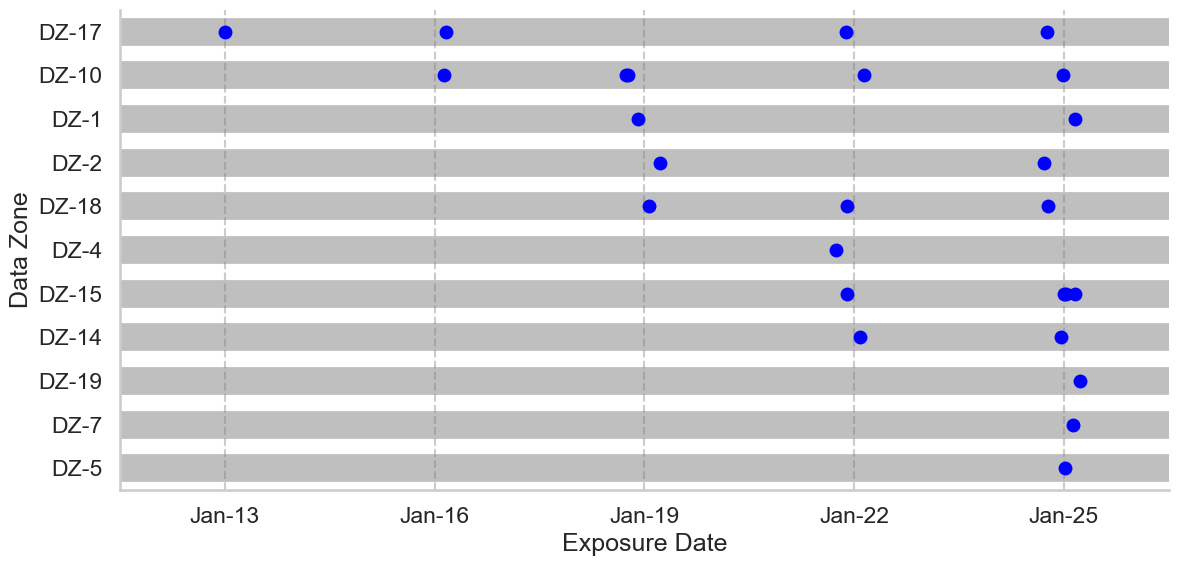

In [19]:
sns.catplot(cases, x="Exposure Date", y="Data Zone", height=6, aspect=2, color="blue", size=10)
plt.grid(True,axis='x', linestyle='--')
plt.grid(True,axis='y', alpha=0.5, linewidth=20, color='grey')
plt.title("", fontsize=25)
plt.savefig("spatio_temporal_analysis_2.png", dpi=300, bbox_inches='tight')
plt.show()

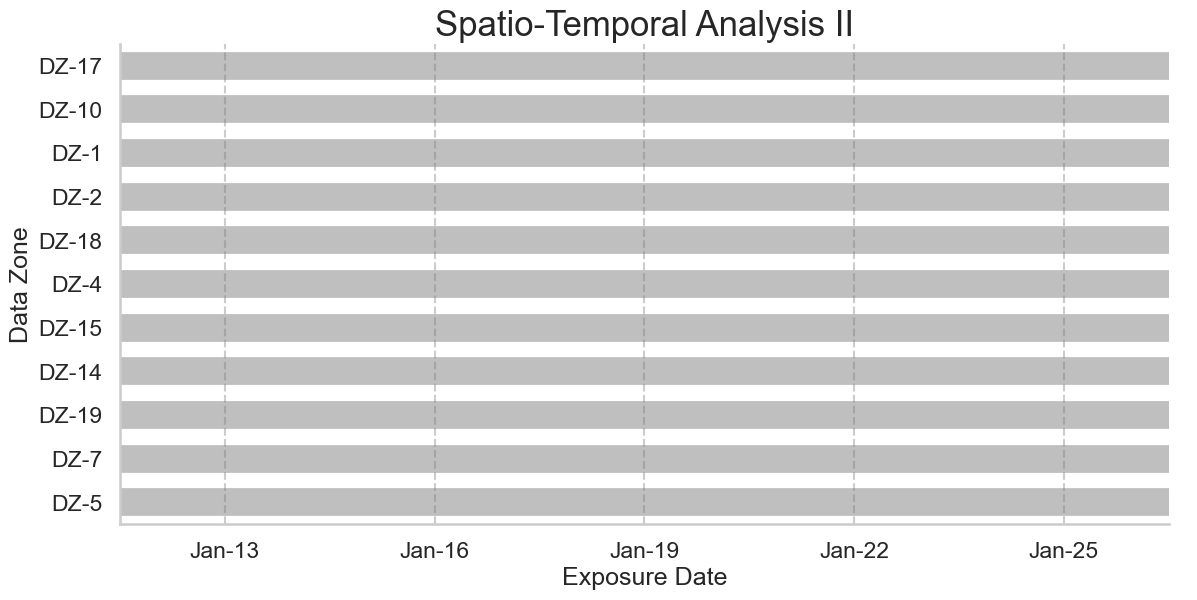

In [20]:
sns.catplot(cases, x="Exposure Date", y="Data Zone", height=6, aspect=2, color="red", marker="p", size=10, alpha=0)
plt.grid(True,axis='x', linestyle='--')
plt.grid(True,axis='y', alpha=0.5, linewidth=20, color='grey')
plt.title("Spatio-Temporal Analysis II", fontsize=25)
plt.savefig("spatio_temporal_analysis_student_2.png", dpi=300, bbox_inches='tight')
plt.show()

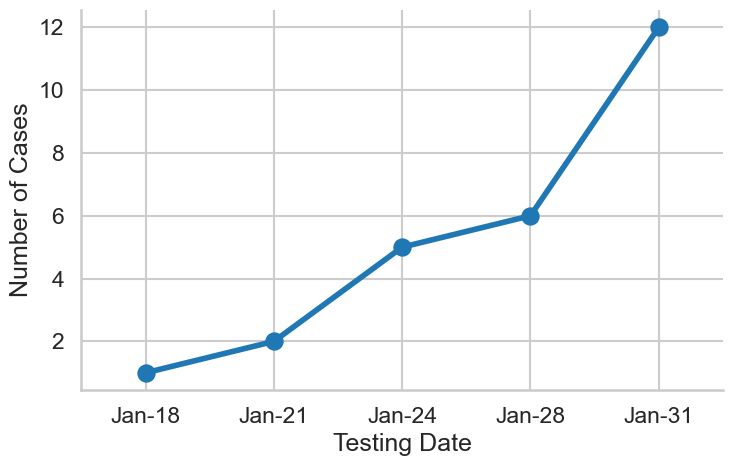

In [21]:
group_cases = cases.groupby("Testing Date").size()

sns.catplot(x=group_cases.index, y=group_cases, kind="point", aspect=1.5)
plt.ylabel("Number of Cases")
plt.grid(True)
plt.savefig("case_count.png", dpi=300, bbox_inches='tight')
plt.show()

In [22]:
def find_intersections(list_of_lists):
    intersections = []
    for i in range(len(list_of_lists)):
        for j in range(i + 1, len(list_of_lists)):
            intersection = set(list_of_lists[i]) & set(list_of_lists[j])
            if intersection:
                intersections.append((i, j, intersection))
    return intersections

# Example usage:
lists = [
    [1, 2, 3],
    [3, 4, 5],
    [6, 7],
    [5, 8, 9]
]

result = find_intersections(cases["Known Contact"].to_list())
print(result[:10])

[(0, 1, {'-', 'P', 'C', ',', '8', '5', '7', ' ', '4', '2', '3', '6', '1'}), (0, 2, {'-', 'C', '8', '7', '4'}), (0, 3, {'-', 'P', 'C', ',', '8', '5', '7', ' ', '4', '2', '3', '6', '1'}), (0, 4, {'-', 'P', 'C', ',', '8', '7', '4', ' ', '2', '3', '6'}), (0, 5, {'-', 'C', '5', '7', '4'}), (0, 6, {'5', '-', 'C', '1'}), (0, 7, {'-', 'P', 'C', ',', '8', '5', '7', ' ', '4', '3', '6', '1'}), (0, 8, {'5', '-', 'C', '8'}), (0, 9, {'-', 'P', 'C', ',', '5', '7', ' ', '2', '3', '6', '1'}), (0, 10, {'-', 'P', 'C', ',', '5', '7', ' ', '2', '3', '6', '1'})]


In [23]:
seq1="".join(outbreak.result.linearSeqSim[0])
seq2="".join(outbreak.result.linearSeqSim[10])

In [24]:
(outbreak.result.linearSeqSim[0] != outbreak.result.linearSeqSim[10]).sum()

np.int64(3)

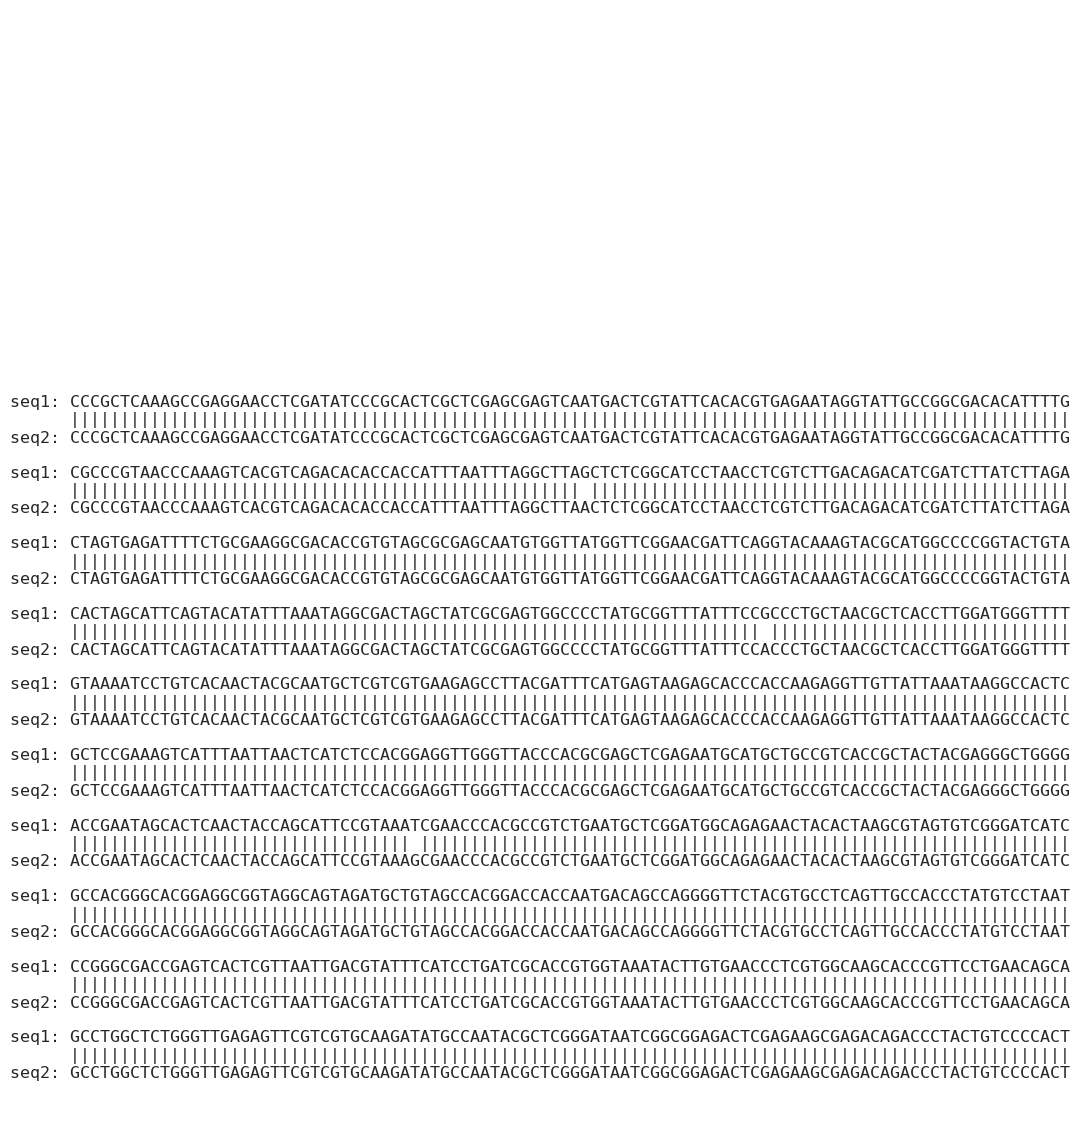

In [25]:
fig, ax = plt.subplots(figsize=(10, 5))
# Hide the axes
ax.axis("off")
ax.text(0, 0, needleman_wunsch.align(seq1, seq2, width=100), fontsize=12, family="monospace", va="top")
plt.savefig("alignment_visualization.png", dpi=300, bbox_inches='tight')
plt.show()